# Data Loading

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender
import warnings
warnings.filterwarnings("ignore")

from rectools import Columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)



In [106]:
import implicit
implicit.__version__

'0.4.4'

In [1]:
import zipfile as zf
import requests

url = "https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip"

req = requests.get(url, stream=True)

with open("kion.zip", "wb") as fd:
    total_size_in_bytes = int(req.headers.get("Content-Length", 0))
    for chunk in req.iter_content(chunk_size=2**20):
        fd.write(chunk)

files = zf.ZipFile("kion.zip", "r")
files.extractall()
files.close()

In [4]:
interactions = pd.read_csv('data_original/interactions.csv')
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [10]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'watched_pct': 'weight',
            },
    inplace=True,
    )

In [18]:
def load_data():
    interactions = pd.read_csv('data_original/interactions.csv')
    users = pd.read_csv('data_original/users.csv')
    items = pd.read_csv('data_original/items.csv')
    interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'watched_pct': 'weight',
            },
    inplace=True,
    )

    interactions['datetime'] = pd.to_datetime(interactions['datetime'])
    return interactions, users, items


# Recommend popular items

In [18]:
def recommend_popular(
    df: pd.DataFrame, k: int = 10, days: int = 7
) -> list:
    """
    Returns most popular items for the last k days
    """

    min_date = df["datetime"].max().normalize() - pd.DateOffset(days)
    result = list(df.loc[df["datetime"] > min_date, "item_id"]
                   .value_counts()
                   .head(k)
                   .index.values)
    return result

In [20]:
recommend_popular(interactions)

[9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512]

# KNN

In [146]:
from collections import Counter
from pathlib import Path
from typing import Dict

import dill
import numpy as np
import pandas as pd
import scipy as sp
from implicit.nearest_neighbours import CosineRecommender, ItemItemRecommender, BM25Recommender, TFIDFRecommender
from rectools import Columns

In [142]:
class UserKnn:
    """Class for fit-perdict UserKNN model
    based on ItemKNN model from implicit.nearest_neighbours
    """

    def __init__(self, model: ItemItemRecommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False

    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train["user_id"].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}

        self.items_inv_mapping = dict(enumerate(train["item_id"].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}

    def get_matrix(
        self,
        df: pd.DataFrame,
        user_col: str = "user_id",
        item_col: str = "item_id",
        weight_col: str = "weight",
        users_mapping: Dict[int, int] = None,
        items_mapping: Dict[int, int] = None,
    ):

        if weight_col:
            weights = df[weight_col].astype(np.float32)
        else:
            weights = np.ones(len(df), dtype=np.float32)

        interaction_matrix = sp.sparse.coo_matrix(
            (
                weights,
                (
                    df[user_col].map(self.users_mapping.get),
                    df[item_col].map(self.items_mapping.get),
                ),
            )
        )

        return interaction_matrix

    def idf(self, n: int, x: float):
        return np.log((1 + n) / (1 + x) + 1)

    def _count_item_idf(self, df: pd.DataFrame):
        item_cnt = Counter(df["item_id"].values)
        item_idf = pd.DataFrame.from_dict(
            item_cnt, orient="index", columns=["doc_freq"]
        ).reset_index()
        item_idf["idf"] = item_idf["doc_freq"].apply(
                            lambda x: self.idf(self.n, x)
        )
        self.item_idf = item_idf

    def fit(self, train: pd.DataFrame):
        self.user_knn = self.model
        self.get_mappings(train)
        self.weights_matrix = self.get_matrix(
            train, users_mapping=self.users_mapping,
            items_mapping=self.items_mapping
        )

        self.n = train.shape[0]
        self._count_item_idf(train)

        self.user_knn.fit(self.weights_matrix)
        
        watched_items_df = (train.groupby("user_id")
                                 .agg({"item_id": list})
                                 .reset_index())
        self.watched_items = {}
        for _, row in watched_items_df.iterrows():
            self.watched_items[row["user_id"]] = row["item_id"]

        self.is_fitted = True

    def _generate_recs_mapper(
        self,
        model: ItemItemRecommender,
        user_mapping: Dict[int, int],
        user_inv_mapping: Dict[int, int],
        N: int,
    ):
        def _recs_mapper(user):
            print(user)
            user_id = user_mapping[user]
            print(user_id)
            recs = model.similar_items(user_id, N=N)
            print(recs)
            return [user_inv_mapping[user] for user, _ in recs], [
                sim for _, sim in recs
            ]

        return _recs_mapper

    def predict(self, test: pd.DataFrame, N_recs: int = 10) -> list:
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn,
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users,
        )
        recs = pd.DataFrame({"user_id": test["user_id"].unique()})
        recs["sim_user_id"], recs["sim"] = zip(*recs["user_id"].map(mapper))
        recs = recs.set_index("user_id").apply(pd.Series.explode).reset_index()
        recs = recs[recs["user_id"] != recs["sim_user_id"]]
        recs["item_id"] = recs["user_id"].apply(
            lambda x: self.watched_items.get(x, [])
        )
        recs = recs.explode("item_id")
        recs = recs.sort_values(["user_id", "sim"], ascending=False)
        recs = recs.drop_duplicates(["user_id", "item_id"], keep="first")
        recs = recs.merge(
            self.item_idf, left_on="item_id", right_on="index", how="left"
        )
        
        recs["score"] = recs["sim"] * recs["idf"]
        recs = recs.sort_values(["user_id", "score"], ascending=False)
        recs["rank"] = recs.groupby("user_id").cumcount() + 1
        recs = recs[recs["rank"] <= N_recs]
        
        return recs


def main():
    # Fit model
    userknn_hot_users = UserKnn(BM25Recommender(), 30)
    userknn_hot_users.fit(interactions)

    # Save model
    with open("userknn_hot_users.dill", "wb") as f:
        dill.dump(userknn_hot_users, f)


In [19]:
interactions, users, items = load_data()

In [20]:
interactions.head()

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [21]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [22]:
items.head(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Грандинетти, Джеральдин Чаплин, Елена Анайя, Каэтано Велозо, Леонор Уотлинг, Лола Дуэньяс, Лолес Леон, Малу Айродо, Мариола Фуэнтес, Пас Вега, Пина Бауш, Ро...",Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий. Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...,"Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких,..."


Разделю пользователей на горячих и теплых/холодных

In [33]:
# Preparing of the Hot Users
interactions_count = interactions.groupby("user_id")[["item_id"]].count().reset_index()
interactions_count

,user_id,item_id
0,0,6
1,1,2
2,2,49
3,3,30
4,4,2
...,...,...
962174,1097553,4
962175,1097554,10
962176,1097555,7
962177,1097556,1


<AxesSubplot:>

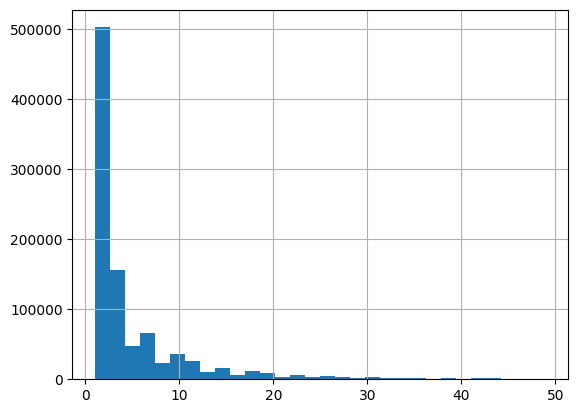

In [35]:
interactions_count[interactions_count.item_id < 50].item_id.hist(bins = 30)

In [84]:
# считаю пользователя горячим, если у него больше 10 взамодействий
hot_users = interactions_count[interactions_count.item_id >= 10].user_id.values
cold_users = interactions_count[~(interactions_count.item_id >= 10)].user_id.values

len(hot_users), len(cold_users)

(145410, 816769)

In [108]:
hot_users, cold_users

(array([      2,       3,       5, ..., 1097534, 1097544, 1097554]),
 array([      0,       1,       4, ..., 1097555, 1097556, 1097557]))

In [85]:
hot_interactions = interactions[interactions["user_id"].isin(hot_users)].sort_values(["user_id", "datetime"])
hot_interactions.shape[0]

3260927

In [86]:
user_type_dict = {i : 'hot' if i in hot_users else 'cold' for i in interactions_count.user_id.values}

In [87]:
with open("user_categories.dill", "wb") as f:
        dill.dump(user_type_dict, f)

In [88]:
#with open("user_categories.dill", "rb") as f:
#        user_type_dict = dill.load(f)

In [89]:
len(user_type_dict)

962179

Обучение и сохранение модели

In [147]:
userknn_hot_users = UserKnn(BM25Recommender(), 50)
userknn_hot_users.fit(hot_interactions)

  0%|          | 0/145410 [00:00<?, ?it/s]

In [148]:
with open("userknn_hot_users.dill", "wb") as f:
        dill.dump(userknn_hot_users, f)

In [113]:
#with open("../models/userknn_hot_users.dill", "rb") as f:
#        userknn_hot_users = dill.load(f)

In [140]:
one_user_df = interactions[interactions["user_id"] == 2][
                    ["user_id", "item_id", "weight"]
                ]

In [116]:
userknn_hot_users.predict(one_user_df)

,user_id,sim_user_id,sim,item_id,index,doc_freq,idf,score,rank
44,2,61324,0.415331,3628,3628,105,10.334116,4.292082,1
3,2,61324,0.415331,8936,8936,154,9.954145,4.134268,2
42,2,61324,0.415331,5819,5819,279,9.362819,3.888672,3
45,2,61324,0.415331,242,242,335,9.180514,3.812955,4
8,2,61324,0.415331,15196,15196,457,8.870794,3.684318,5
1,2,61324,0.415331,11577,11577,551,8.684144,3.606797,6
41,2,61324,0.415331,7921,7921,557,8.673335,3.602308,7
43,2,61324,0.415331,12449,12449,589,8.617581,3.579151,8
40,2,61324,0.415331,8482,8482,594,8.609143,3.575647,9
39,2,61324,0.415331,7106,7106,622,8.563167,3.556551,10


In [104]:
def full_reco_items_list(
    arr_reco_after_model: np.array, pop_array: np.array, number: int
) -> list:
    """
    Add number of items from pop_array to arr_reco_after_model.
    Return array of 10 unique items
    """

    CONST_K = 10

    size_of_array = np.unique(arr_reco_after_model).size
    if size_of_array == CONST_K:
        return arr_reco_after_model

    # all duplicates will be deleting and adding some items from pop_array
    def del_repeat_items(full_arr_mix_pop: np.array, k: int = CONST_K) -> np.array:
        """
        Delete all duplicates items in array
        """

        size_of_array = np.unique(full_arr_mix_pop).size
        if size_of_array == CONST_K:
            return full_arr_mix_pop
        else:
            # delete duplicates and save the order of items
            full_arr_mix_pop = full_arr_mix_pop[
                np.sort(np.unique(full_arr_mix_pop, return_index=True)[1])
            ]
            # add new items from pop_array
            i = k - size_of_array
            full_arr_mix_pop = np.concatenate(
                (full_arr_mix_pop, np.random.choice(pop_array, i, replace=False))
            )
            return del_repeat_items(full_arr_mix_pop)

    full_arr_mix_pop = np.array([])
    full_arr_mix_pop = np.concatenate((arr_reco_after_model, pop_array[:number]))
    full_arr_mix_pop = del_repeat_items(full_arr_mix_pop)

    return list(full_arr_mix_pop)


def knn_make_predict(model, data: pd.DataFrame, list_pop_items: list) -> list:
    """
    Gets predict after bas-model and add lacking items(to 10)
    for each user if it needed
    """

    predict = model.predict(data, 10)
    predict = predict["item_id"].unique()

    predict_len = len(predict)
    
    if predict_len < 10:
        predict = predict + list_pop_items[:(10-predict_len)]


    return list(predict)

In [144]:
knn_make_predict(userknn_hot_users, one_user_df, [9728, 15297, 10440, 14488, 13865, 12192, 341, 4151, 3734, 512])

2
0
[(0, 1.0000000000000002), (8034, 0.41533132465235023), (113635, 0.38479562935785155), (51087, 0.3490052135373378), (84625, 0.3121651038877771), (97851, 0.3092264487933854), (99443, 0.3064587001163053), (142163, 0.3050362209545266), (55068, 0.30449460173004084), (75762, 0.3034352234600651), (90379, 0.30329077967634205), (113677, 0.30168531974290846), (91583, 0.30144846179060486), (90155, 0.3014420526664354), (117669, 0.30096091377328715), (95988, 0.30087080729733046), (69217, 0.2984967169702066), (39124, 0.29612446187430697), (66804, 0.2940629594697141), (86139, 0.29357212102455577)]


[3628, 8936, 5819, 242, 15196, 11577, 7921, 12449, 8482, 7106]

In [145]:
implicit.__version__

'0.4.4'